In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
import shap

## Basic Lightgbm

In [2]:
df = pd.read_excel("C:\\Users\\s\\Desktop\\Dersler\\Data Informatics\\DI502\\Github\\Electricity_Consmption_EPIAS_data.xlsx")

dates_dt = pd.to_datetime(df.Tarih, format='%d.%m.%Y')
    
df.Tarih = dates_dt.copy()
df = df.sort_values("Tarih")

In [3]:
df['year']=df['Tarih'].dt.year 
df['month']=df['Tarih'].dt.month
df['day']=df['Tarih'].dt.day
df['season']=df['Tarih'].dt.quarter
df['week']=df['Tarih'].dt.isocalendar().week
df['dayofweek']=df['Tarih'].dt.dayofweek
df['hour']= df.Saat.astype("str").apply(lambda x: x[:2]).astype("int")

df = df.sort_values(["year","month","day","hour"])

target = "Tüketim Miktarı (MWh)"

df[target] =  pd.Series([item.replace(".", "").replace(",",".") for item in df.loc[:,target]]).astype("float64")

In [4]:
train = df[df.Tarih <= "2023-09-30"].reset_index(drop=True).copy()
test = df[df.Tarih > "2023-09-30"].reset_index(drop=True).copy()

In [5]:
best_params = {"learning_rate": 0.11867001834319307,
"max_depth" : 6, 
"n_estimators": 474,
"num_leaves": 29,
"reg_alpha": 50,
"reg_lambda": 97,
"subsample": 0.8}

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\s\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 7
[LightGBM] [Info] Start training from score 37127.426340
r2: 0.9640585951580282 rmse: 848.691965173023


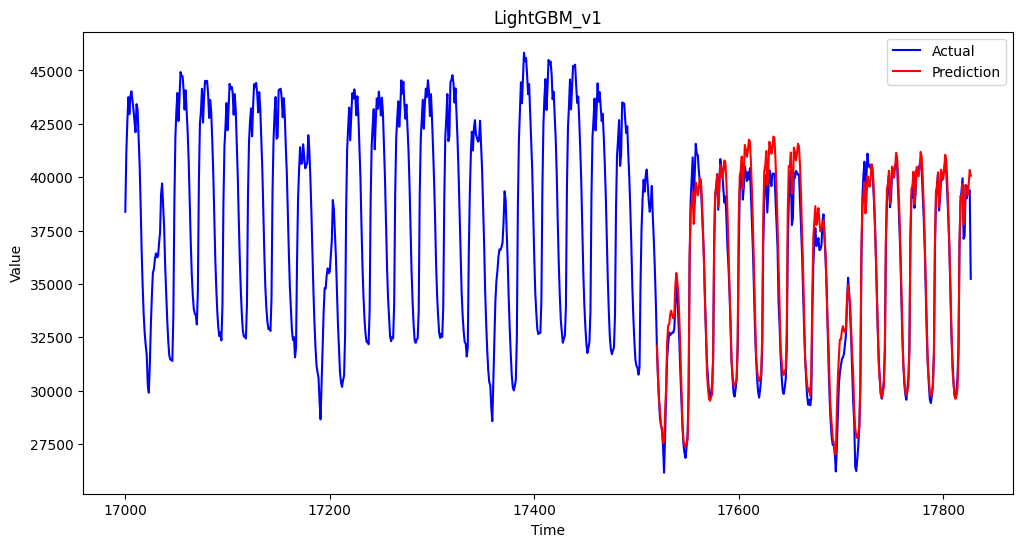

In [6]:
x_train = train.iloc[:,-7:]
x_test = test.iloc[:,-7:]
y_train = train.loc[:,target]
y_test = test.loc[:,target]

eval_set = [(x_test,y_test)]
basic_model = LGBMRegressor(random_state=42,verbose=1,**best_params)
basic_model.fit(x_train, y_train,eval_set=eval_set)

y_predicted = pd.Series(basic_model.predict(x_test))
rmse = mean_squared_error(y_test, y_predicted, squared=False)
r2 = r2_score(y_test, y_predicted)
print("r2:",r2, "rmse:", rmse)

y_predicted.index = range(17520,17828)

plt.figure(figsize=(12, 6))
plt.plot(df.loc[17000:,"Tüketim Miktarı (MWh)"], label='Actual', color='blue')
plt.plot(y_predicted, label='Prediction', color='red',)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LightGBM_v1')
plt.legend()
plt.show()

     feature  importance
6       hour        3067
4       week        3066
2        day        2409
5  dayofweek        1792
1      month        1744
0       year        1194
3     season           0


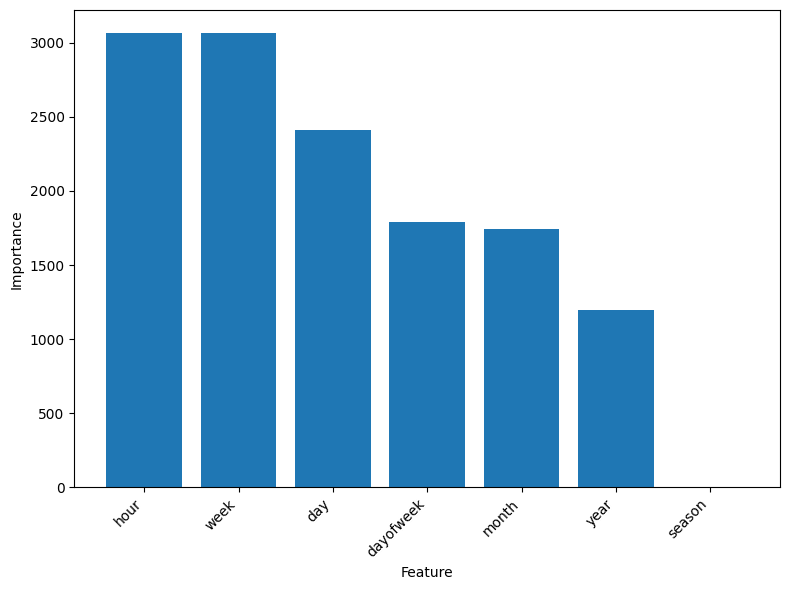

In [7]:
# Get feature importances from the trained model
feature_importances = basic_model.feature_importances_

# Get feature names (assuming your training data has column names)
feature_names = train.columns[-7:]

# Create a pandas dataframe with feature names and importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the dataframe by importance in descending order
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Print the dataframe with feature names and their corresponding importances
print(importance_df)

# Optionally, visualize feature importance using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
shap_values = shap.TreeExplainer(basic_model).shap_values(x_test)

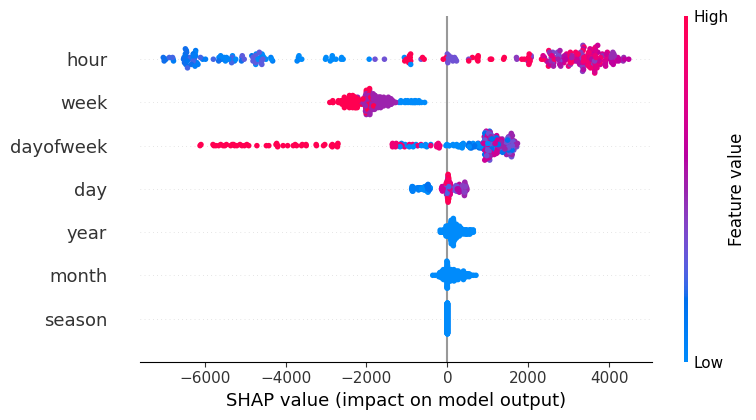

In [16]:
shap.summary_plot(shap_values, x_test)